In [57]:
import sys, os
from glob import glob
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import QuantileTransformer, quantile_transform, PowerTransformer, power_transform
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.compose import TransformedTargetRegressor
# TransformedTargetRegressor = for log transformed target , =QuantileTransformer=robut against outliers
from sklearn.metrics import PredictionErrorDisplay # for evaluation with and without transfomred target
from sklearn.pipeline import Pipeline
from scipy import stats

import matplotlib.pyplot as plt

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines_continous as p

s.init()
seed = s.seed

import warnings
warnings.filterwarnings('ignore')


transformation = True ##False
targets = ["Target_contentloss_euro", "Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[2]

In [58]:
os.getcwd()
#f.plot_spearman_rank()

'c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\feature-selection-from-remote-fs\\model_preprocessing\\Feature_selection'

In [59]:
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss.xlsx")
df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction.xlsx")




## Clean dataset from features and records with too many missing values


In [60]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 
#df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
#print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
## --> drops content values if threshold == 15%


Percentage of missing values per feature
 elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.158690
shp_registered_capital_euro                    0.118388
Target_businessreduction                       0.090680
shp_risk_tolerance                             0.070529
perception_who_responsible4protection.Rank1    0.070529
bage                                           0.068010
perception_private_economy_future              0.065491
hh_monthly_income_cat                          0.060453
resilience_govern_careing                      0.057935
resilience_govern_warnings_helpful             0.045340
shp_monetary_resources4prevention              0.045340
shp_profits_last5years                         0.037783
resilience_city_protection                     0.037783
resilience_more_future_affected                0.037783
dtype: float64


In [61]:
# ## TODO fix missing values by removing them:
## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time

## number of missing values for each predictor and for each case
# df_candidates_t.isna().sum().sort_values(ascending=False)
#t = df_candidates_t.drop(["perception_govern_support_future", "warning_time_h"], axis=1)
# t.isna().sum().sum()

# df_candidates.isna().sum(axis=1).sort_values(ascending=False) # nan per case


### Test drop features with high correlation to other features

In [62]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# df_vif = pd.DataFrame()
# df_vif["features"] = X_unscaled.columns
# df_candidates_X_filled = X_unscaled.replace(np.nan, 0)
# df_vif["vif_scores"] = [variance_inflation_factor(df_candidates_X_filled.values.astype(float), i)  for i in range(len(df_candidates_X_filled.columns))]
# df_vif.sort_values("vif_scores", ascending=False)  

# print("averaged VIF score is around: ", round(df_vif.vif_scores.mean(),1))
# print(df_vif.sort_values("vif_scores", ascending=False)  )
# # VIF >5 : high correlation
# # VIF 1-10: medium correlation


### Test. examine three hihest content loss records

In [63]:
# print("Highest content damages: \n", df_candidates[target].nlargest(5) )#.index

# highest_closs_obs = df_candidates[target].nlargest(3).index.to_list()
# df_candidates = df_candidates.drop(highest_closs_obs, axis=0)
# print("Dropped three records with the three highest content losses")

### Test drop features with variance around zero

In [64]:
# pd.options.display.float_format = '{:.5f}'.format

# df_variance = pd.DataFrame({"name": df_candidates.columns, "variance": df_candidates.var(), }).reset_index(drop=True)
# df_variance = df_variance.loc[df_variance.variance > 0.0000, :]
# print(df_variance.shape)
# df_variance.variance = df_variance.variance.astype(float)
# df_variance.sort_values("variance", ascending=True) [:10]
# ## same result as with # from sklearn.feature_selection import VarianceThreshold


Except for contamination types and supplier location the dataset fro buisness reduction hasnt much options for feature redction based on small variance scores close to zero. 
For content loss variable no suitable feautre with low variance could be find. 
*CHECK if correct: Some variabels have small variance due that they were quite ofte napplied e.g.emergency measures and therefoe just show a small variation from their mean value ?*

## select only observations with content loss

Lambda box-cox 0.07601254439106622


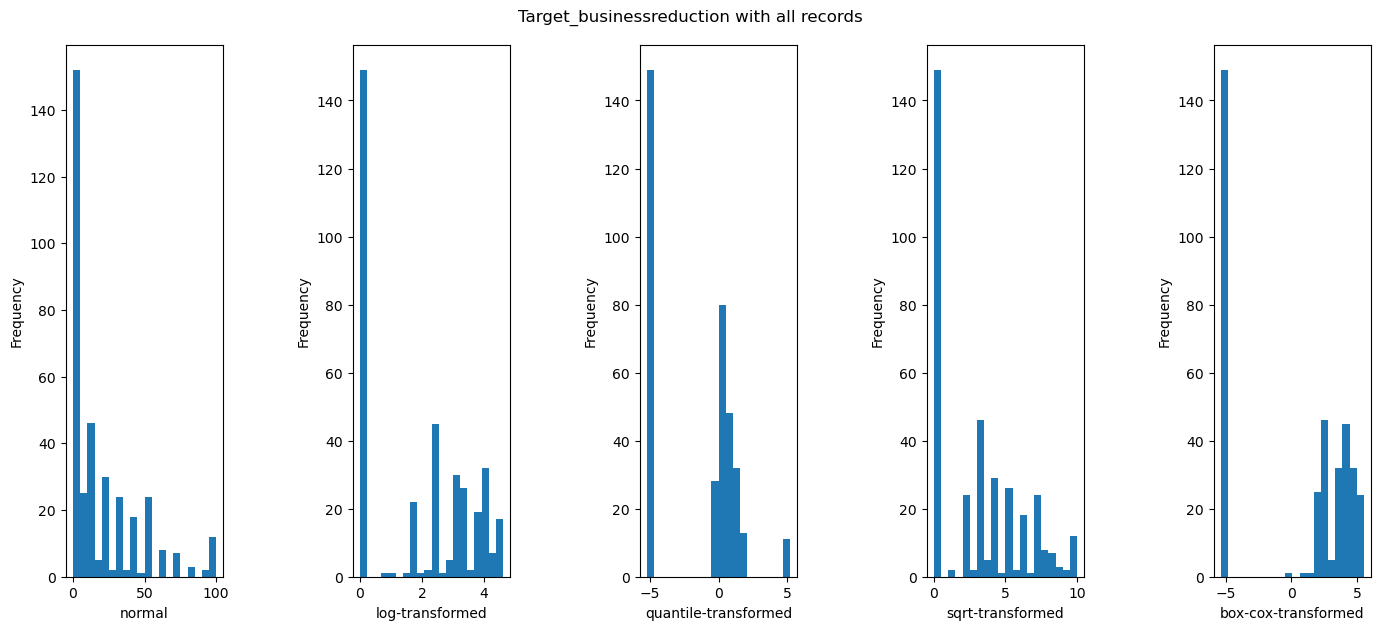

In [65]:
from scipy import stats

y = df_candidates[target]
y_log = np.log1p(y)
y_quantile = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True).squeeze()
y_sqrt = np.sqrt(y)
y_prep = y.dropna() + 0.001
y_boxcox, y_lambda = stats.boxcox(y_prep)  # boxcox only without nan in target
print("Lambda box-cox", y_lambda)

#Below we plot the probability density functions of the target before and after applying the logarithmic functions.
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(15, 8))

ax0.hist(y, bins=20)
#ax0.set_xlim([0, 100])
#ax0.set_xlim([0, 10000])
ax0.set_ylabel("Frequency")
ax0.set_xlabel("normal")

ax1.hist(y_log, bins=20,)
ax1.set_ylabel("Frequency")
ax1.set_xlabel(f"log-transformed")


ax2.hist(y_quantile, bins=20,)
ax2.set_ylabel("Frequency")
ax2.set_xlabel(f"quantile-transformed")


ax3.hist(y_sqrt, bins=20,)
ax3.set_ylabel("Frequency")
ax3.set_xlabel(f"sqrt-transformed")

ax4.hist(y_boxcox, bins=20,)
ax4.set_ylabel("Frequency")
ax4.set_xlabel(f"box-cox-transformed")

f.suptitle(f"{y.name} with all records", y=0.85)
plt.tight_layout(pad=5.0)


In [66]:
print(f"Removing {df_candidates.loc[df_candidates[target]==0,:].shape[0]} zero loss records")
df_candidates = df_candidates.loc[df_candidates[target]!=0,:]

print(f"Keeping {df_candidates.shape} damage cases for model training and evaluation")

Removing 149 zero loss records
Keeping (248, 48) damage cases for model training and evaluation


### Plot tagret vs its log- and qunatile-transformed version

Lambda box-cox 0.1465986166646437


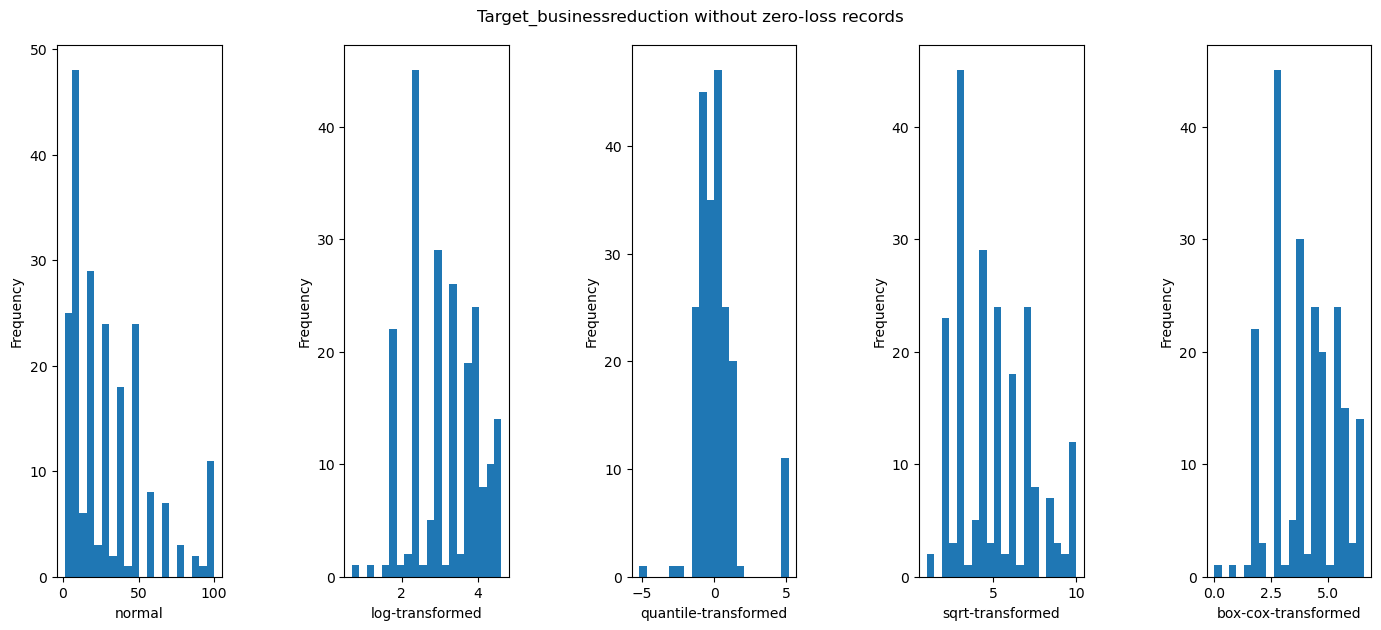

In [68]:
y = df_candidates[target]

y_log = np.log1p(y)
y_quantile = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True).squeeze()
y_sqrt = np.sqrt(y)
y_prep = y.dropna() + 0.001
y_boxcox, y_lambda = stats.boxcox(y_prep)  # boxcox only without nan in target
print("Lambda box-cox", y_lambda)


#Below we plot the probability density functions of the target before and after applying the logarithmic functions.
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(15, 8))

ax0.hist(y, bins=20)
#ax0.set_xlim([0, 100])
#ax0.set_xlim([0, 10000])
ax0.set_ylabel("Frequency")
ax0.set_xlabel("normal")

ax1.hist(y_log, bins=20,)
ax1.set_ylabel("Frequency")
ax1.set_xlabel(f"log-transformed")

ax2.hist(y_quantile, bins=20,)
ax2.set_ylabel("Frequency")
ax2.set_xlabel(f"quantile-transformed")

ax3.hist(y_sqrt, bins=20,)
ax3.set_ylabel("Frequency")
ax3.set_xlabel(f"sqrt-transformed")

ax4.hist(y_boxcox, bins=20,)
ax4.set_ylabel("Frequency")
ax4.set_xlabel(f"box-cox-transformed")

f.suptitle(f"{y.name} without zero-loss records", y=0.85)
plt.tight_layout(pad=5.0)


### Box-Cox transformation

Test Box-Cox transformation to find if the approach gives a good suggestion which transformation might be most useful to obtain a more normal distributed target. 

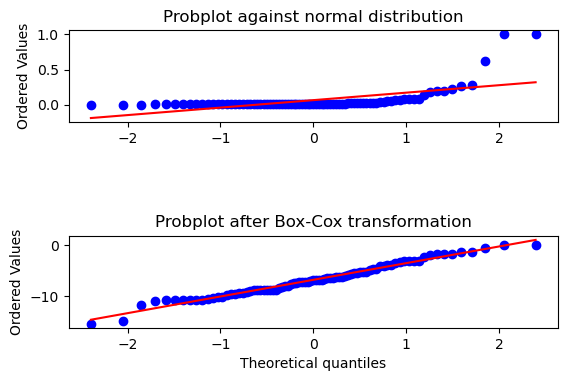

In [ ]:
df_candidates = df_candidates.dropna()  # boxcox doesnt accept nan
y = df_candidates[target]

## apply box cox transfomration to get best normal distribution
try: 
    fitted_y, fitted_lambda = stats.boxcox(y)
except ValueError:
        fitted_y, fitted_lambda = stats.boxcox(y+1)

#df_candidates[target] = fitted_y


## plot new and old distribution
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_subplot(211)
prob = stats.probplot(y, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
prob = stats.probplot(fitted_y, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')


plt.tight_layout(pad=5.0)
plt.show()

best lambda: -0.16267168711961832


<Axes: ylabel='Density'>

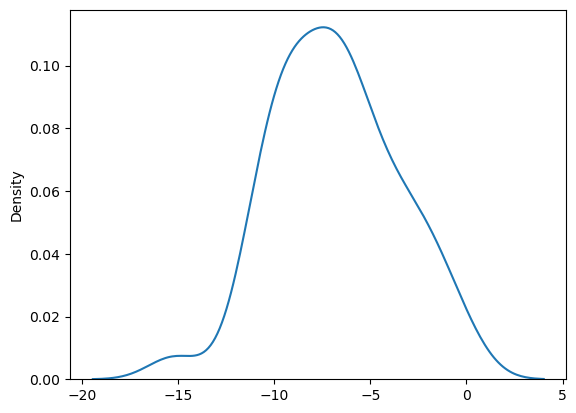

In [ ]:
print("best lambda:", fitted_lambda)
# lambda = -1. is a reciprocal transform.
# lambda = -0.5 is a reciprocal square root transform.
# lambda = 0.0 is a log transform.
# lambda = 0.5 is a square root transform.
# lambda = 1.0 is no transform.

##  --> best transformation would be achieved with reciprocal transformation

import seaborn as sns
#sns.distplot(y, hist=False, kde=True) 
sns.distplot(fitted_y, hist=False, kde=True) 


In [ ]:
df_candidates.shape

(83, 42)

### Test remove and merging further features

In [ ]:
#df_candidates.info()

#df_candidates = df_candidates.dropna()

In [ ]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()
# d = scaler.fit_transform(X_unscaled)
# X_scaled = pd.DataFrame(d, columns=X_unscaled.columns)

# df_vif = pd.DataFrame()
# df_vif["X_features"] =  X_unscaled.columns

# ## fill possible important features with median, only for VIF calculation
# for f in ["shp_registered_capital_euro", "elevation_building_height_cm",  "shp_content_value_euro"]:
#     X_scaled[f"{f}"] = X_scaled[f"{f}"].replace(np.nan, np.nanmedian(X_scaled[f"{f}"]))

# X_scaled_drop_nan = X_scaled.dropna()

# print(X_scaled.shape)
# print(X_scaled_drop_nan.shape)

# df_vif = fs.vif_score(X_scaled_drop_nan)
# print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )
# # VIF >10 : high correlation with other features
# # VIF 1-5: medium correlation

### Test PCA or PLS on resilience and perception features

In [ ]:
# df_candidates = df_candidates.drop([
#         "contaminations_light", "contaminations_heavy", "emergency_measures.9",
#         "emergency_measures.6", "emergency_measures.7", # BETTER DROP test rmv da nur binary
#         "elevation_rel2surrounding_cat",  # TEST
#         #"shp_profits_last5years", # TEST
#         "shp_monetary_resources4prevention", # TEST
#         'shp_finance_investments',
#         'shp_risk_tolerance',
#         'resilience_city_protection', 'resilience_left_alone',
#         'resilience_neighbor_management', 
#         # already in d_cleaning RM 'resilience_more_future_affected','resilience_govern_careing', 'resilience_govern_careing_increases',
#         'perception_who_responsible4protection.Rank1',
#         # ALREADY RM in d_cleaning: 'perception_private_economy_future' 
#         ], axis=1)


In [ ]:
sys.path.insert(0, "../../../")
import utils.utils_figures as f

(83, 41)


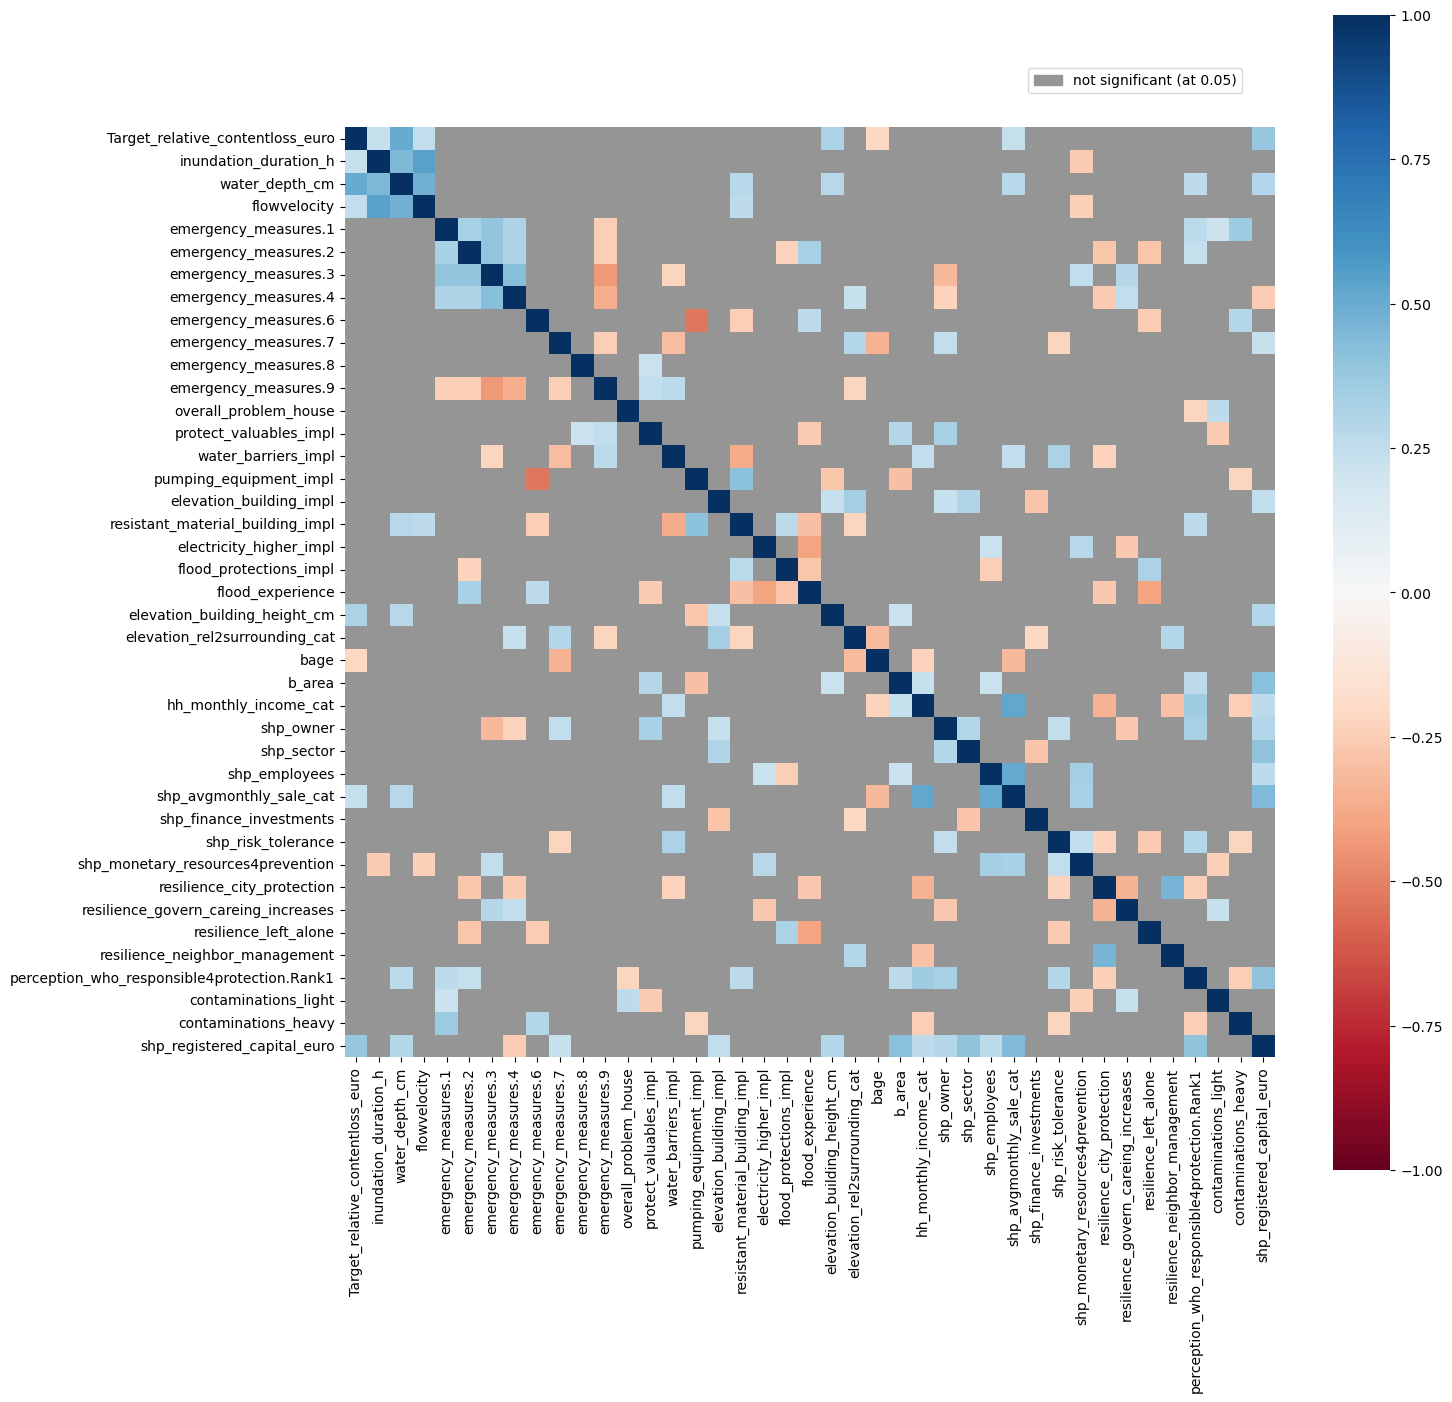

In [ ]:
print(df_candidates.shape)

plt.figure(figsize=(15, 15))
f.plot_spearman_rank(df_candidates, min_periods=10, signif=True, psig=0.05)


In [ ]:
# importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame(
#     {"importances" : importances[0]},
#     index=X_train.columns.to_list(),
#     ) 
# df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
# print("Most important features:", df_importance.iloc[:5].index.to_list())
# #df_importance = df_importance.loc[df_importance.importances >= 0.000000, : ]

# df_importance